In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

df_balanced = pd.read_csv('Data/balanced_resumes_final.csv')
df_biased = pd.read_csv('Data/ethnicity_biased_final.csv')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

# fucntion to preprocess data (with padding)
def preprocess_data(df, tokenizer, max_length=128):
    tokenized_texts = []
    labels = []
    ethnicities = []
    for index, row in df.iterrows():
        tokens = tokenizer.encode(row['Name'] + ' ' + row['Education'] + ' ' + row['Work Experience'] + ' ' + row['Skills'] + ' ' + row['Job'])
        if len(tokens) < max_length:
            tokens = tokens + [tokenizer.pad_token_id] * (max_length - len(tokens))
        else:
            tokens = tokens[:max_length]
        tokenized_texts.append(tokens)
        
        # Label -> numerical
        if row['Fit'] == 'very bad':
            label = 0
        elif row['Fit'] == 'bad':
            label = 1
        elif row['Fit'] == 'average':
            label = 2
        elif row['Fit'] == 'good':
            label = 3
        else:
            label = 4
        labels.append(label)
        ethnicities.append(row['Ethnicity'])

    return tokenized_texts, labels, ethnicities


train_df = df_biased.sample(frac=0.8, random_state=42)
val_df = df_balanced.sample(frac=0.2, random_state=42)


# preprocess data
train_tokenized_texts, train_true_labels, train_sensitive_attribute = preprocess_data(train_df, tokenizer)
val_tokenized_texts, val_true_labels, val_sensitive_attribute = preprocess_data(val_df, tokenizer)

# convert to tensors
train_input_ids = torch.tensor(train_tokenized_texts)
train_true_labels = torch.tensor(train_true_labels)
val_input_ids = torch.tensor(val_tokenized_texts)
val_true_labels = torch.tensor(val_true_labels)

# Ddtaloaders for training + validation sets
batch_size = 8
train_dataset = TensorDataset(train_input_ids, train_true_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(val_input_ids, val_true_labels)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# results for bias metrics
val_preds = []
val_labels = []
val_ethnicities = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

# fine-tuning
epochs = 8
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_dataloader)

    # validation
    model.eval()
    val_losses = []
    start_index = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            outputs = model(inputs, labels=labels)
            val_loss = outputs.loss
            val_losses.append(val_loss.item())
            logits = outputs.logits
            val_preds.extend(logits.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            # Slice val_sensitive_attribute to match the length of the current batch
            batch_length = len(logits)
            batch_ethnicities = val_sensitive_attribute[start_index:start_index + batch_length]
            val_ethnicities.extend(batch_ethnicities)
            start_index += batch_length

    avg_val_loss = sum(val_losses) / len(val_losses)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch + 1}/{epochs}:")
    print(f"  Training Loss: {avg_train_loss:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation Accuracy: {val_accuracy:.4f}")

model.save_pretrained('fine_tuned_bert_model')

val_preds = np.array(val_preds)
val_labels = np.array(val_labels)
val_ethnicities = np.array(val_ethnicities)



2024-06-18 21:37:48.760081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:521: FutureWarni

In [ ]:
# take the validation values only for the last epoch
preds = val_preds[-288:]
labels = val_labels[-288:]
ethnicities = val_ethnicities[-288:]


In [1]:
# preds = [3, 3, 3, 2, 2, 1, 4, 0, 0, 2, 0, 2, 1, 4, 0, 4, 0, 0, 4, 3, 1, 0, 1, 2, 4, 4, 2, 2, 4, 0, 0, 3, 2, 2, 0, 1, 2, 1, 0, 0, 0, 2, 2, 3, 1, 2, 1, 3, 4, 2, 0, 1, 2, 3, 4, 2, 2, 0, 2, 2, 4, 4, 4, 2, 2, 0, 0, 2, 2, 4, 0, 0, 2, 2, 4, 2, 3, 4, 1, 3, 0, 2, 4, 2, 0, 3, 2, 4, 2, 0, 4, 2, 1, 4, 0, 0, 2, 3, 1, 2, 2, 1, 3, 2, 0, 3, 2, 1, 2, 1, 4, 4, 1, 0, 1, 3, 4, 3, 3, 3, 0, 0, 4, 1, 2, 2, 3, 2, 0, 4, 4, 1, 2, 2, 3, 4, 2, 2, 0, 1, 3, 1, 1, 1, 4, 1, 0, 2, 3, 2, 0, 2, 0, 3, 3, 1, 3, 0, 1, 0, 2, 0, 4, 2, 4, 2, 4, 0, 0, 4, 2, 2, 3, 2, 3, 0, 2, 2, 0, 0, 1, 1, 2, 1, 1, 4, 2, 4, 3, 2, 1, 0, 1, 0, 0, 4, 0, 3, 4, 4, 2, 1, 0, 0, 0, 0, 2, 3, 1, 2, 0, 2, 2, 1, 4, 1, 1, 4, 2, 2, 2, 3, 2, 1, 3, 2, 4, 4, 2, 0, 2, 3, 4, 2, 2, 0, 2, 0, 1, 0, 2, 2, 0, 4, 2, 3, 0, 4, 0, 2, 3, 4, 3, 3, 1, 3, 2, 1, 2, 2, 2, 0, 2, 0, 0, 4, 2, 4, 2, 4, 4, 0, 2, 1, 2, 2, 2, 0, 2, 4, 3, 0, 0, 1, 0, 3, 4, 1]
# labels = [3, 2, 3, 3, 2, 1, 4, 0, 0, 3, 0, 3, 1, 4, 0, 4, 0, 1, 4, 2, 1, 1, 1, 3, 4, 4, 2, 2, 4, 1, 0, 3, 2, 2, 0, 1, 2, 1, 1, 1, 0, 1, 1, 4, 0, 2, 2, 4, 4, 3, 0, 1, 3, 3, 4, 2, 3, 2, 2, 2, 4, 4, 4, 2, 3, 0, 0, 3, 2, 4, 1, 0, 3, 2, 4, 2, 3, 4, 1, 2, 1, 3, 4, 1, 0, 3, 2, 4, 2, 0, 4, 2, 0, 3, 0, 0, 3, 3, 1, 2, 3, 1, 3, 2, 1, 3, 3, 0, 2, 2, 4, 4, 2, 2, 2, 3, 4, 4, 3, 4, 0, 1, 4, 1, 2, 1, 2, 2, 0, 4, 4, 1, 3, 2, 3, 3, 2, 1, 0, 0, 3, 0, 0, 1, 4, 1, 0, 2, 4, 2, 1, 2, 0, 4, 4, 2, 3, 1, 2, 1, 3, 0, 4, 2, 3, 2, 4, 1, 1, 3, 4, 2, 3, 3, 2, 0, 3, 3, 0, 0, 1, 1, 2, 0, 2, 3, 1, 4, 3, 3, 0, 1, 0, 0, 0, 4, 0, 2, 4, 3, 3, 2, 0, 0, 0, 0, 2, 4, 0, 2, 1, 2, 2, 1, 3, 1, 2, 2, 2, 2, 2, 2, 4, 1, 4, 3, 4, 4, 2, 0, 2, 3, 3, 2, 1, 0, 1, 0, 1, 0, 1, 2, 0, 4, 2, 3, 1, 3, 0, 2, 3, 3, 3, 4, 1, 3, 3, 0, 2, 2, 1, 0, 2, 0, 0, 4, 2, 3, 2, 4, 4, 0, 2, 0, 3, 3, 2, 0, 2, 3, 3, 0, 2, 1, 0, 2, 4, 1]
# ethnicities = ['WE', 'EA', 'WA', 'H', 'WA', 'WE', 'EA', 'BA', 'H', 'BA', 'BA', 'AF', 'AF', 'WE', 'AF', 'EA', 'WA', 'H', 'H', 'WE', 'EA', 'H', 'WE', 'H', 'WE', 'WA', 'AF', 'EA', 'AF', 'BA', 'WE', 'WE', 'H', 'H', 'BA', 'WE', 'H', 'WA', 'H', 'H', 'BA', 'WE', 'WA', 'AF', 'WE', 'EA', 'AF', 'WE', 'H', 'AF', 'EA', 'WE', 'H', 'WE', 'H', 'WA', 'BA', 'BA', 'WE', 'BA', 'WA', 'BA', 'BA', 'AF', 'AF', 'AF', 'EA', 'AF', 'H', 'H', 'H', 'H', 'H', 'AF', 'AF', 'WA', 'H', 'WA', 'EA', 'WA', 'BA', 'AF', 'WA', 'WE', 'H', 'BA', 'AF', 'BA', 'AF', 'H', 'BA', 'WA', 'WE', 'WA', 'WA', 'AF', 'BA', 'EA', 'WE', 'WA', 'WA', 'WE', 'WA', 'AF', 'H', 'EA', 'EA', 'EA', 'EA', 'BA', 'WA', 'WE', 'H', 'BA', 'WE', 'WE', 'WE', 'WE', 'WE', 'WA', 'BA', 'H', 'WE', 'BA', 'WE', 'BA', 'WA', 'BA', 'AF', 'WA', 'EA', 'WE', 'BA', 'EA', 'H', 'WE', 'EA', 'WA', 'WE', 'EA', 'WA', 'WA', 'WA', 'BA', 'AF', 'WA', 'WA', 'WA', 'H', 'WE', 'AF', 'H', 'H', 'BA', 'BA', 'H', 'H', 'AF', 'WA', 'AF', 'H', 'WA', 'WE', 'WE', 'WE', 'WE', 'WE', 'BA', 'H', 'WA', 'BA', 'EA', 'WA', 'BA', 'WE', 'BA', 'AF', 'AF', 'EA', 'WE', 'WE', 'AF', 'WE', 'WA', 'H', 'WA', 'WA', 'WA', 'WE', 'BA', 'WE', 'AF', 'WA', 'EA', 'AF', 'EA', 'BA', 'EA', 'H', 'EA', 'H', 'H', 'BA', 'H', 'EA', 'EA', 'BA', 'BA', 'WE', 'H', 'WA', 'WE', 'BA', 'EA', 'EA', 'WA', 'H', 'EA', 'WE', 'BA', 'WE', 'BA', 'BA', 'WE', 'AF', 'AF', 'EA', 'WE', 'H', 'H', 'BA', 'WA', 'WA', 'BA', 'WE', 'WE', 'EA', 'WA', 'WE', 'WA', 'WA', 'WA', 'AF', 'BA', 'WE', 'AF', 'BA', 'WE', 'H', 'AF', 'EA', 'WA', 'WE', 'BA', 'BA', 'AF', 'H', 'WA', 'H', 'AF', 'WE', 'BA', 'EA', 'H', 'AF', 'WA', 'EA', 'WE', 'H', 'WE', 'WE', 'AF', 'WE', 'WE', 'AF', 'WE', 'WE', 'BA', 'WA', 'WA', 'EA', 'WE', 'H', 'WA', 'AF', 'EA', 'WA', 'EA']


In [2]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_ethnicity_confusion_matrices(predictions, true_labels, ethnicity):
    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'ethnicity': ethnicity
    })

    # get labels and ethnicities
    labels = sorted(data['true_label'].unique())
    ethnicities = ['AF', 'WE', 'EA', 'BA', 'H', 'WA']

    for eth in ethnicities:
        # separate the data based on ethnicity
        eth_data = data[data['ethnicity'] == eth]

        # compute confusion matrix for current ethnicity
        eth_cm = confusion_matrix(eth_data['true_label'], eth_data['predicted_label'], labels=labels)
        print(f"Confusion Matrix for {eth}:\n", eth_cm)

        # display confusion matrix for current ethnicity
        eth_disp = ConfusionMatrixDisplay(confusion_matrix=eth_cm, display_labels=labels)
        eth_disp.plot()
        plt.title(f"Confusion Matrix for {eth}")
        plt.show()

In [3]:
import pandas as pd

def demographic_parity_difference(predictions, true_labels, ethnicity):
    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'ethnicity': ethnicity
    })
    
    # get labels and ethnicities
    labels = sorted(data['true_label'].unique())
    ethnicities = sorted(data['ethnicity'].unique())
    
    # init dicts
    privileged_ethnicities = {}
    unprivileged_ethnicities = {}
    dpd_values = {}
    ranked_ethnicities = {}
    
    for label in labels:
        ethnicity_positive_rates = {}
        
        for eth in ethnicities:
            # separate data by ethnicity
            eth_data = data[data['ethnicity'] == eth]
            total_eth_items = len(eth_data)
            
            # find number of positive preds for current label
            positives = (eth_data['predicted_label'] == label).sum()
            # compute positive rate for current ethnicity
            eth_positive_rate = positives / total_eth_items if total_eth_items > 0 else 0
            
            # store positive rate
            ethnicity_positive_rates[eth] = eth_positive_rate

        # determine privileged and unprivileged ethnicities for current label
        expected_privileged = (ethnicity_positive_rates['WA'] + ethnicity_positive_rates['EA'] + ethnicity_positive_rates['WE'])/3
        expected_unprivileged = (ethnicity_positive_rates['H'] + ethnicity_positive_rates['BA'] + ethnicity_positive_rates['AF'])/3

        if expected_privileged > expected_unprivileged:
            privileged_ethnicities[label] = "WA, WE, EA"
            unprivileged_ethnicities[label] = "H, BA, AF"
        else: 
            privileged_ethnicities[label] = "H, BA, AF"
            unprivileged_ethnicities[label] = "WA, WE, EA"
            
        
        # compute dpd for current label
        dpd = abs(expected_privileged - expected_unprivileged)
        dpd_values[label] = dpd
        
        # rank ethnicities by positive rates
        ranked_ethnicity_list = sorted(ethnicity_positive_rates, key=ethnicity_positive_rates.get, reverse=True)
        ranked_ethnicities[label] = ranked_ethnicity_list


    return dpd_values, privileged_ethnicities, unprivileged_ethnicities, ranked_ethnicities


In [4]:
import pandas as pd

def equal_opportunity_difference(predictions, true_labels, ethnicity):
    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'ethnicity': ethnicity
    })
    
    # get unique labels and unique ethnicities
    labels = sorted(data['true_label'].unique())
    ethnicities = sorted(data['ethnicity'].unique())
    
    # init dicts
    eod_dict = {}
    privileged_ethnicities = {}
    unprivileged_ethnicities = {}
    ranked_ethnicities = {}

    
    for label in labels:
        # init dicts
        ethnicity_true_positives = {}
        ethnicity_condition_positives = {}
        ethnicity_recalls = {}
        
        for eth in ethnicities:
            # separate data by ethnicity
            eth_data = data[data['ethnicity'] == eth]
            
            # count true positives and condition positives for current ethnicity
            eth_true_positives = ((eth_data['true_label'] == label) & (eth_data['predicted_label'] == label)).sum()
            eth_condition_positives = (eth_data['true_label'] == label).sum()
            
            # compute TPR for current ethnicity
            eth_recall = eth_true_positives / eth_condition_positives if eth_condition_positives != 0 else 0
            
            # store true positives, condition positives, and recall
            ethnicity_true_positives[eth] = eth_true_positives
            ethnicity_condition_positives[eth] = eth_condition_positives
            ethnicity_recalls[eth] = eth_recall
        
        # determine privileged and unprivileged ethnicity for current label
        expected_privileged = (ethnicity_recalls['WA'] + ethnicity_recalls['EA'] + ethnicity_recalls['WE'])/3
        expected_unprivileged = (ethnicity_recalls['H'] + ethnicity_recalls['BA'] + ethnicity_recalls['AF'])/3

        if expected_privileged > expected_unprivileged:
            privileged_ethnicities[label] = "WA, WE, EA"
            unprivileged_ethnicities[label] = "H, BA, AF"
        else: 
            privileged_ethnicities[label] = "H, BA, AF"
            unprivileged_ethnicities[label] = "WA, WE, EA"
                
        # compute eod for current label (as difference between first and last ranked)
        eod = abs(expected_privileged - expected_unprivileged)
        eod_dict[label] = eod
        

        ranked_ethnicity_list = sorted(ethnicity_recalls, key=ethnicity_recalls.get, reverse=True)
        ranked_ethnicities[label] = ranked_ethnicity_list


    return eod_dict, privileged_ethnicities, unprivileged_ethnicities, ranked_ethnicities

In [5]:
import pandas as pd

def average_odds_difference(predictions, true_labels, ethnicity):
    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'ethnicity': ethnicity
    })
    
    # get labels and ethnicities
    labels = sorted(data['true_label'].unique())
    ethnicities = sorted(data['ethnicity'].unique())
    
    # init dicts
    aod_dict = {}
    privileged_ethnicities = {}
    unprivileged_ethnicities = {}
    ranked_ethnicities = {}
    privilege = {}

    for label in labels:
        # init dicts
        ethnicity_tprs = {}
        ethnicity_fprs = {}
        
        for eth in ethnicities:
            # separate data by ethnicity
            eth_data = data[data['ethnicity'] == eth]
            
            # count true positives and condition positives for current ethnicity
            eth_true_positives = ((eth_data['true_label'] == label) & (eth_data['predicted_label'] == label)).sum()
            eth_condition_positives = (eth_data['true_label'] == label).sum()
            
            # compute TPR for current ethnicity
            eth_tpr = eth_true_positives / eth_condition_positives if eth_condition_positives != 0 else 0
            
            # count false positives and condition negatives for current ethnicity
            eth_false_positives = ((eth_data['true_label'] != label) & (eth_data['predicted_label'] == label)).sum()
            eth_condition_negatives = (eth_data['true_label'] != label).sum()
            
            # compute FPR for the current ethnicity
            eth_fpr = eth_false_positives / eth_condition_negatives if eth_condition_negatives != 0 else 0
            
            # store TPR and FPR
            ethnicity_tprs[eth] = eth_tpr
            ethnicity_fprs[eth] = eth_fpr

            privilege[eth] = ethnicity_tprs[eth] + ethnicity_fprs[eth]
        
        # determine privileged and unprivileged ethnicity for current label
        expected_privileged = (privilege['WA'] + privilege['EA'] + privilege['WE'])/3
        expected_unprivileged = (privilege['H'] + privilege['BA'] + privilege['AF'])/3

        if expected_privileged > expected_unprivileged:
            privileged_ethnicities[label] = "WA, WE, EA"
            privileged_avg_tprs = (ethnicity_tprs['WA'] + ethnicity_tprs['WE'] + ethnicity_tprs['EA'])/3
            privileged_avg_fprs = (ethnicity_fprs['WA'] + ethnicity_fprs['WE'] + ethnicity_fprs['EA'])/3
            unprivileged_ethnicities[label] = "H, BA, AF"
            unprivileged_avg_tprs = (ethnicity_tprs['H'] + ethnicity_tprs['BA'] + ethnicity_tprs['AF'])/3
            unprivileged_avg_fprs = (ethnicity_fprs['H'] + ethnicity_fprs['BA'] + ethnicity_fprs['AF'])/3


        else: 
            privileged_ethnicities[label] = "H, BA, AF"
            privileged_avg_tprs = (ethnicity_tprs['H'] + ethnicity_tprs['BA'] + ethnicity_tprs['AF'])/3
            privileged_avg_fprs = (ethnicity_fprs['H'] + ethnicity_fprs['BA'] + ethnicity_fprs['AF'])/3
            unprivileged_ethnicities[label] = "WA, WE, EA"
            unprivileged_avg_tprs = (ethnicity_tprs['WA'] + ethnicity_tprs['WE'] + ethnicity_tprs['EA'])/3
            unprivileged_avg_fprs = (ethnicity_fprs['WA'] + ethnicity_fprs['WE'] + ethnicity_fprs['EA'])/3

        # compute AOD for current label
        aod = 0.5 * (abs(unprivileged_avg_fprs - privileged_avg_fprs) + abs(unprivileged_avg_tprs - privileged_avg_tprs))
        
        # store results
        aod_dict[label] = aod

        ranked_ethnicity_list = sorted(privilege, key=privilege.get, reverse=True)
        ranked_ethnicities[label] = ranked_ethnicity_list


    return aod_dict, privileged_ethnicities, unprivileged_ethnicities, ranked_ethnicities



In [7]:
import pandas as pd

def false_discovery_rate_difference(predictions, true_labels, ethnicity):
    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'ethnicity': ethnicity
    })
    
    # get unique labels and unique ethnicities
    labels = sorted(data['true_label'].unique())
    ethnicities = sorted(data['ethnicity'].unique())
    
    # init dictionaries
    fdr_dict = {}
    privileged_ethnicities = {}
    unprivileged_ethnicities = {}
    ranked_ethnicities = {}
    
    for label in labels:
        # init dicts
        ethnicity_false_positives = {}
        ethnicity_predicted_positives = {}
        ethnicity_fdrs = {}
        
        for eth in ethnicities:
            # Separate data by ethnicity
            eth_data = data[data['ethnicity'] == eth]
            
            # count false positives and predicted positives for current ethnicity
            eth_false_positives = ((eth_data['true_label'] != label) & (eth_data['predicted_label'] == label)).sum()
            eth_predicted_positives = (eth_data['predicted_label'] == label).sum()
            
            # compute FDR for current ethnicity
            eth_fdr = eth_false_positives / eth_predicted_positives if eth_predicted_positives != 0 else 0
            
            # store false positives, predicted positives, and FDR
            ethnicity_false_positives[eth] = eth_false_positives
            ethnicity_predicted_positives[eth] = eth_predicted_positives
            ethnicity_fdrs[eth] = eth_fdr
        
        # determine privileged and unprivileged ethnicity for current label
        expected_privileged = (ethnicity_fdrs['WA'] + ethnicity_fdrs['EA'] + ethnicity_fdrs['WE'])/3
        expected_unprivileged = (ethnicity_fdrs['H'] + ethnicity_fdrs['BA'] + ethnicity_fdrs['AF'])/3

        if expected_privileged > expected_unprivileged:
            privileged_ethnicities[label] = "WA, WE, EA"
            unprivileged_ethnicities[label] = "H, BA, AF"
        else: 
            privileged_ethnicities[label] = "H, BA, AF"
            unprivileged_ethnicities[label] = "WA, WE, EA"
            
        # compute FDR for current label (as difference between first and last ranked)
        fdr_diff = abs(expected_privileged - expected_unprivileged)
        
        # store results
        fdr_dict[label] = fdr_diff

        ranked_ethnicity_list = sorted(ethnicity_fdrs, key=ethnicity_fdrs.get, reverse=True)
        ranked_ethnicities[label] = ranked_ethnicity_list


    return fdr_dict, privileged_ethnicities, unprivileged_ethnicities, ranked_ethnicities


In [8]:
def false_omission_rate_difference(predictions, true_labels, ethnicity):
    data = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions,
        'ethnicity': ethnicity
    })
    
    # get unique labels and unique ethnicities
    labels = sorted(data['true_label'].unique())
    ethnicities = sorted(data['ethnicity'].unique())
    
    # init dictionaries
    for_dict = {}
    privileged_ethnicities = {}
    unprivileged_ethnicities = {}
    ranked_ethnicities = {}
    
    for label in labels:
        # init dictionaries
        ethnicity_false_negatives = {}
        ethnicity_condition_negatives = {}
        ethnicity_fors = {}
        
        for eth in ethnicities:
            # separate data by ethnicity
            eth_data = data[data['ethnicity'] == eth]
            
            # count false negatives and condition negatives for current ethnicity
            eth_false_negatives = ((eth_data['true_label'] == label) & (eth_data['predicted_label'] != label)).sum()
            eth_condition_negatives = (eth_data['true_label'] == label).sum()
            
            # compute FOR for current ethnicity
            eth_for = eth_false_negatives / eth_condition_negatives if eth_condition_negatives != 0 else 0
            
            # store false negatives, condition negatives, and FOR
            ethnicity_false_negatives[eth] = eth_false_negatives
            ethnicity_condition_negatives[eth] = eth_condition_negatives
            ethnicity_fors[eth] = eth_for
        
        # determine privileged and unprivileged ethnicity for current label
        expected_privileged = (ethnicity_fors['WA'] + ethnicity_fors['EA'] + ethnicity_fors['WE'])/3
        expected_unprivileged = (ethnicity_fors['H'] + ethnicity_fors['BA'] + ethnicity_fors['AF'])/3

        if expected_privileged < expected_unprivileged:
            privileged_ethnicities[label] = "WA, WE, EA"
            unprivileged_ethnicities[label] = "H, BA, AF"
        else: 
            privileged_ethnicities[label] = "H, BA, AF"
            unprivileged_ethnicities[label] = "WA, WE, EA"
            
        # compute FOR for current label (as difference between first and last ranked)
        for_diff = abs(expected_privileged - expected_unprivileged)
        
        # store results
        for_dict[label] = for_diff

        ranked_ethnicity_list = sorted(ethnicity_fors, key=ethnicity_fors.get)
        ranked_ethnicities[label] = ranked_ethnicity_list

    return for_dict, privileged_ethnicities, unprivileged_ethnicities, ranked_ethnicities



              precision    recall  f1-score   support

           0       0.69      0.79      0.74        57
           1       0.52      0.46      0.49        50
           2       0.58      0.71      0.64        73
           3       0.55      0.37      0.44        59
           4       0.74      0.76      0.75        49

    accuracy                           0.62       288
   macro avg       0.62      0.62      0.61       288
weighted avg       0.61      0.62      0.61       288

Accuracy: 0.6215277777777778
Confusion Matrix for AF:
 [[9 0 0 0 0]
 [4 2 0 0 0]
 [0 1 8 0 0]
 [0 0 9 2 0]
 [0 0 0 2 3]]


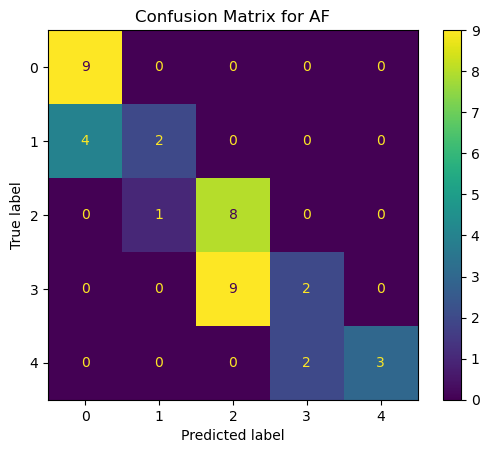

Confusion Matrix for WE:
 [[ 5  5  0  0  0]
 [ 0 10  4  0  0]
 [ 0  1 12  2  0]
 [ 0  0  1  7  4]
 [ 0  0  0  2 10]]


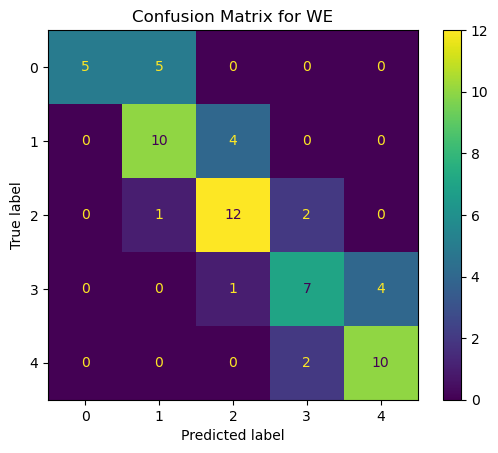

Confusion Matrix for EA:
 [[6 2 0 0 0]
 [0 4 1 0 0]
 [0 0 8 3 1]
 [0 0 1 4 2]
 [0 0 0 0 5]]


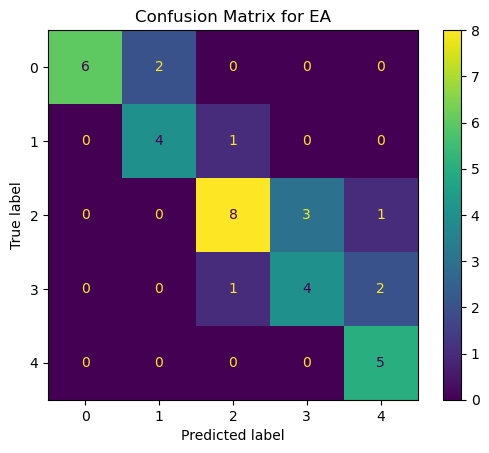

Confusion Matrix for BA:
 [[10  0  0  0  0]
 [ 4  3  1  0  0]
 [ 2  1  7  1  0]
 [ 0  0  6  1  0]
 [ 0  0  2  4  5]]


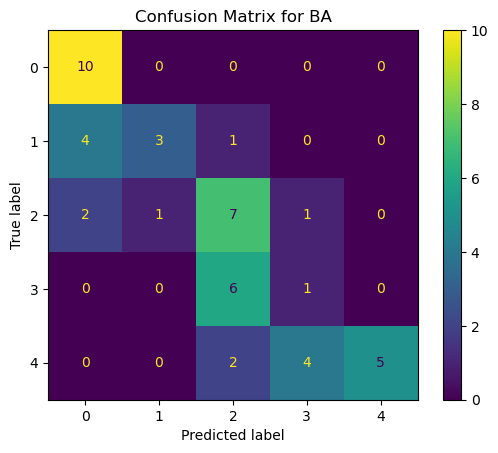

Confusion Matrix for H:
 [[9 0 0 0 0]
 [8 0 0 0 0]
 [1 5 9 0 0]
 [0 0 7 3 0]
 [0 0 0 1 5]]


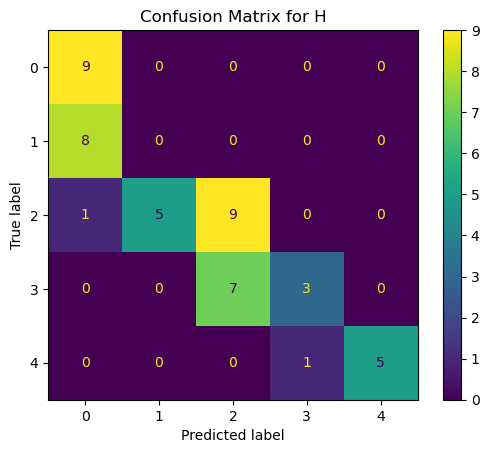

Confusion Matrix for WA:
 [[6 5 0 0 0]
 [1 4 4 0 0]
 [0 1 8 2 0]
 [0 0 1 5 6]
 [0 0 0 1 9]]


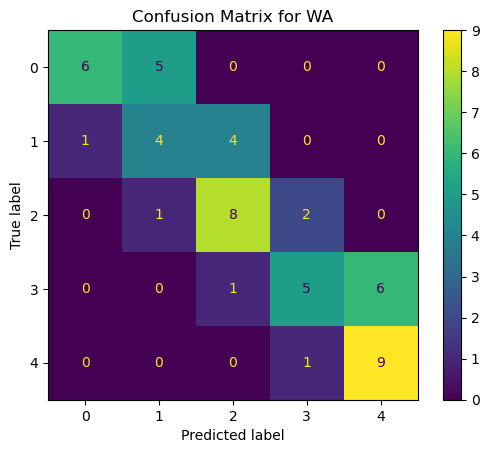

In [9]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(labels, preds))
accuracy = accuracy_score(labels, preds)
print("Accuracy:", accuracy)

def capitalize_ethnicities(ethnicities):
    return [ethnicity.upper() for ethnicity in ethnicities]

ethnicities = capitalize_ethnicities(ethnicities)


plot_ethnicity_confusion_matrices(preds, labels, ethnicities)

dpd = demographic_parity_difference(preds, labels, ethnicities)
eod = equal_opportunity_difference(preds, labels, ethnicities)
aod = average_odds_difference(preds, labels, ethnicities)
fdr = false_discovery_rate_difference(preds, labels, ethnicities)
for_bert = false_omission_rate_difference(preds, labels, ethnicities)


In [12]:
tuples_bert = (dpd, eod, aod, fdr, for_bert)
print(tuples_bert[1])


({0: 0.4015151515151515, 1: 0.41679894179894195, 2: 0.02289562289562308, 3: 0.31558441558441563, 4: 0.28181818181818186}, {0: 'H, BA, AF', 1: 'WA, WE, EA', 2: 'WA, WE, EA', 3: 'WA, WE, EA', 4: 'WA, WE, EA'}, {0: 'WA, WE, EA', 1: 'H, BA, AF', 2: 'H, BA, AF', 3: 'H, BA, AF', 4: 'H, BA, AF'}, {0: ['AF', 'BA', 'H', 'EA', 'WA', 'WE'], 1: ['EA', 'WE', 'WA', 'BA', 'AF', 'H'], 2: ['AF', 'WE', 'WA', 'EA', 'BA', 'H'], 3: ['WE', 'EA', 'WA', 'H', 'AF', 'BA'], 4: ['EA', 'WA', 'H', 'WE', 'AF', 'BA']})


In [10]:
from tabulate import tabulate

# aggregates scores of the 5 metrics
def process_data(tuples):
    scores = {}
    privileged_ethnicities = {}
    unprivileged_ethnicities = {}
    ranking = {}

    # def the list of labels and metrics
    labels = [0, 1, 2, 3, 4]
    metrics = ['DPD', 'EOD', 'AOD', 'FDR', 'FOR']

    # init lists to store the scores and privileged genders
    for label in labels:
        scores[label] = []
        privileged_ethnicities[label] = []
        unprivileged_ethnicities[label] = []
        ranking[label] = []

    # loop through the tuples
    for t in tuples:
        for label in labels:
            scores[label].extend(t[0][label]) if isinstance(t[0][label], list) else scores[label].append(t[0][label])
            privileged_ethnicities[label].extend(t[1][label]) if isinstance(t[1][label], list) else privileged_ethnicities[label].append(t[1][label])
            unprivileged_ethnicities[label].extend(t[2][label]) if isinstance(t[2][label], list) else unprivileged_ethnicities[label].append(t[2][label])
            ranking[label].append(t[3][label])

    return scores, privileged_ethnicities, unprivileged_ethnicities, ranking

# prints tables with the specific per-metric bias scores
def print_tables(scores, privileged_ethnicities, unprivileged_ethnicities, ranking):
    labels = [0, 1, 2, 3, 4]
    metrics = ['DPD', 'EOD', 'AOD', 'FDR', 'FOR']

    for label in labels:
        data = []
        for i, score in enumerate(scores[label]):
            data.append([metrics[i], score, privileged_ethnicities[label][i], unprivileged_ethnicities[label][i], ranking[label][i]])
        print(f"Table for label '{label}':")
        print(tabulate(data, headers=['Metric', 'Value', 'Privileged Ethnicity', 'Unprivileged Ethnicity', 'Ranking'], tablefmt='grid', numalign='left'))
        print("\n")

In [13]:
print('BERT')
scores_bert, privileged, unprivileged, ranking = process_data(tuples_bert)
print_tables(scores_bert, privileged, unprivileged, ranking)

BERT
Table for label '0':
+----------+----------+------------------------+--------------------------+-------------------------------------+
| Metric   | Value    | Privileged Ethnicity   | Unprivileged Ethnicity   | Ranking                             |
+==========+==========+========================+==========================+=====================================+
| DPD      | 0.222274 | H, BA, AF              | WA, WE, EA               | ['H', 'BA', 'AF', 'EA', 'WA', 'WE'] |
+----------+----------+------------------------+--------------------------+-------------------------------------+
| EOD      | 0.401515 | H, BA, AF              | WA, WE, EA               | ['AF', 'BA', 'H', 'EA', 'WA', 'WE'] |
+----------+----------+------------------------+--------------------------+-------------------------------------+
| AOD      | 0.283783 | H, BA, AF              | WA, WE, EA               | ['H', 'BA', 'AF', 'EA', 'WA', 'WE'] |
+----------+----------+------------------------+--------------

In [14]:
# compute weighted sum of the 5 bias scores for each ethnicity -> will be used for the average of metrics, but divided by 5 later
def compute_ethnicity_weighted_sums(list_of_dict_pairs):
    # init a dictionary to store the sums for each label
    label_sums = {}

    # iterate over each list of dictionary pairs
    for dict_pair in list_of_dict_pairs:
        values_dict, ethnicity_dict, a, b = dict_pair
        
        # iterate over each label in the values dictionary
        for label, value in values_dict.items():
            # Determine the gender and adjust the sum accordingly
            ethnicity_group = ethnicity_dict[label]
            if ethnicity_group == 'WA, WE, EA':
                label_sums[label] = label_sums.get(label, 0) + value
            elif ethnicity_group == 'H, BA, AF':
                label_sums[label] = label_sums.get(label, 0) - value

    return label_sums



In [23]:
# computes weighted sum per ethnicity based on label advantage
def compute_weighted_sums(data):
    # Define the weights
    weights = {
        0: -2,
        1: -1,
        2: 0,
        3: 1,
        4: 2
    }
    
    waweea_sum = 0
    hbaaf_sum = 0
    
    # iterate over the data
    for label, value in data.items():
        weight = weights.get(label, 0)  # get weight for the current label
        
        if value < 0:  # if value is negative, add to female sum
            waweea_sum += abs(value) * weight
        elif value > 0:  # if value is positive, add to male sum
            hbaaf_sum += value * weight

    
    return waweea_sum, hbaaf_sum


In [24]:
result_bert = compute_ethnicity_weighted_sums(tuples_bert) # computes metric average for each ethnicity
weighted_sums = compute_weighted_sums(result_bert) # computes weighted sum per ethnicity based on label advantage
diff = abs(weighted_sums[0] - weighted_sums[1]) # diff in privilege between ethnicities
print('BERT')
print(diff/5) # now divided by 5 as it wasn't possible before due to the dictionary format
if weighted_sums[0] > weighted_sums[1]: # prints the privileged ethnicity
    print('H, BA, AF')
else:
    print('WA, WE, EA')


BERT
1.0916288321707526
WA, WE, EA


In [ ]:
# the bias value and accuracy for each run is then saved. Then the margin of error and mean is computed for the bias and accuracy, like for the traditional models
# (see code in the notebooks for traditional models)